In [1]:
import multimodal_cci as mmcci
import scanpy as sc
import numpy as np

#### Load stLearn data objects

In [ ]:
# Patient samples

# 6747: vis4, cosmx1, 
# 21031: vis2, cosmx2, cosmx3
# 48974: vis1, cosmx4, cosmx5, cosmx6
# 66487: vis3, cosmx7, cosmx8

In [39]:
visium = [
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/vis1_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/vis2_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/vis3_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/vis4_cci.h5ad")
]

xenium = [
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/xenium1_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/xenium2_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/xenium3_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/xenium4_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/xenium5_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/xenium6_cci.h5ad")
]

cosmx = [
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/cosmx0_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/cosmx1_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/cosmx2_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/cosmx3_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/cosmx4_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/cosmx5_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/cosmx6_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/cosmx7_cci.h5ad")
]

visium_cci = [sample.uns['per_lr_cci_cell_type'] for sample in visium]
xenium_cci = [sample.uns['per_lr_cci_cell_type'] for sample in xenium]
cosmx_cci = [sample.uns['per_lr_cci_cell_type'] for sample in cosmx]

visium_sizes = [sample.shape[0] for sample in visium]
xenium_sizes = [sample.shape[0] for sample in xenium]
cosmx_sizes = [sample.shape[0] for sample in cosmx]

In [40]:
cell_type_replacements = {
    'KC.Basal': 'KC Basal',
    'KC_Basal': 'KC Basal',
    'KC.Cycling': 'KC Cycling',
    'KC_Cyc': 'KC Cycling',
    'KC_Diff': 'KC Differentiating',
    'KC_Other': 'KC Other',
    'NK.T': 'NK + T',
    'B.PDC': 'B + PDC',
    'B...PDC': 'B + PDC',
                     }
for i in range(len(visium_cci)):
    for lr_pair in visium_cci[i].keys():
        visium_cci[i][lr_pair].rename(index=cell_type_replacements, columns=cell_type_replacements, inplace=True)

for i in range(len(xenium_cci)):
    for lr_pair in xenium_cci[i].keys():
        xenium_cci[i][lr_pair].rename(index=cell_type_replacements, columns=cell_type_replacements, inplace=True)

for i in range(len(cosmx_cci)):
    for lr_pair in cosmx_cci[i].keys():
        cosmx_cci[i][lr_pair].rename(index=cell_type_replacements, columns=cell_type_replacements, inplace=True)

#### Normalise each group of samples

In [41]:
visium_normalised = mmcci.it.normalise_samples_to_target(visium_cci, visium_sizes, target=visium_sizes[0])
xenium_normalised = mmcci.it.normalise_samples_to_target(xenium_cci, xenium_sizes, target=xenium_sizes[0])
cosmx_normalised = mmcci.it.normalise_samples_to_target(cosmx_cci, cosmx_sizes, target=cosmx_sizes[0])

#### Subset to only LR pairs present in majority of samples

In [42]:
lr_pairs = mmcci.it.get_majority_lr_pairs(visium_normalised + xenium_normalised + cosmx_normalised)

#### Calculate average value of each LR pair across each group

In [43]:
visium_avg = mmcci.it.get_avg_lr_pairs(visium_normalised, lr_pairs)
xenium_avg = mmcci.it.get_avg_lr_pairs(xenium_normalised, lr_pairs)
cosmx_avg = mmcci.it.get_avg_lr_pairs(cosmx_normalised, lr_pairs)

#### Normalise samples between technologies

In [44]:
normalised = mmcci.it.normalise_samples_between_tech([[visium_avg], [xenium_avg], [cosmx_avg]])

#### Integrate between technologies for both groups

In [45]:
normalised = np.array(normalised).T.tolist() # Transpose to get lists of groups instead of techs
integrated = mmcci.it.integrate_between_tech(normalised[0])

#### Calculate overall interactions network per group

In [46]:
overall = mmcci.it.calculate_overall_interactions(integrated)

#### Plot overall network

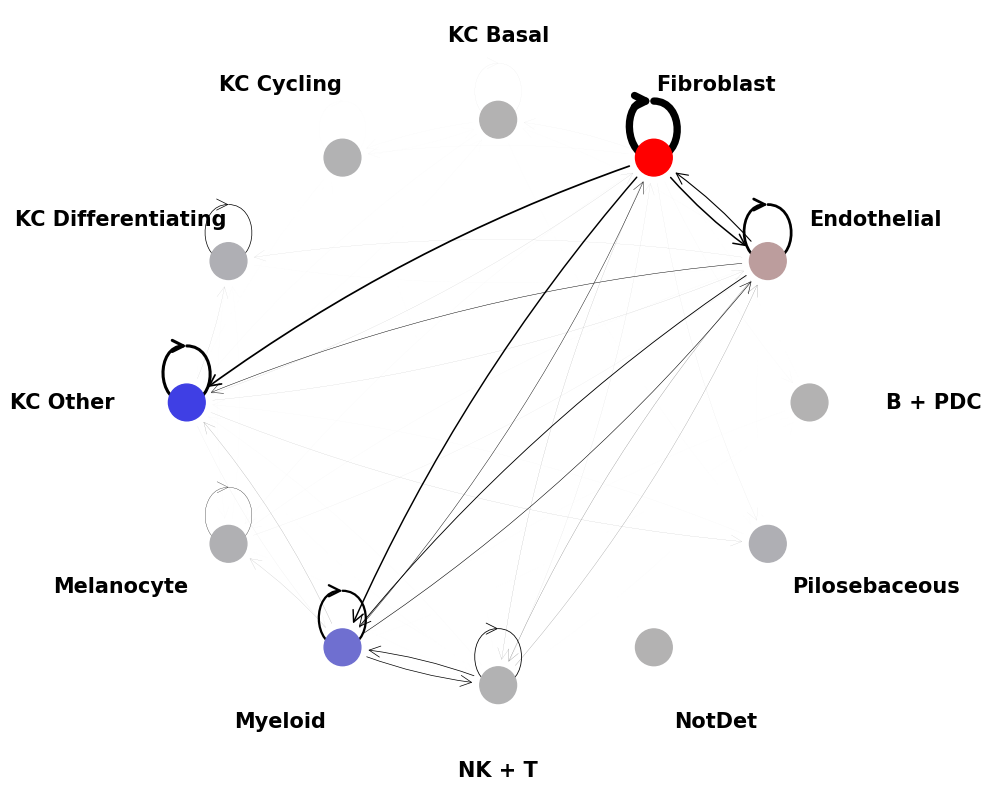

In [47]:
mmcci.plt.network_plot(overall)

#### Get LR pairs from Vascular to Astrocytes

In [48]:
myl_mel_lrs = mmcci.it.get_lrs_per_celltype([integrated], "Myeloid", "Melanocyte")
print("LR pairs from Myeloid to Melanocyte")
print(myl_mel_lrs['sample1'])

LR pairs from Myeloid to Melanocyte
{'ICAM1_ITGAX': 0.31048302978960446, 'MRC1_PTPRC': 0.1775815797704124, 'PTPRC_MRC1': 0.1775815797704124, 'SPP1_ITGB1': 0.1025267728835666, 'ICAM1_ITGB2': 0.09761482508480067, 'COL18A1_ITGB1': 0.06433503939091348, 'TNFSF12_CD163': 0.047827958576945794, 'CCL19_CCR7': 0.022049214733344258}


#### Cluster aged and young lr pairs

Processing: 100%|██████████| 181/181 [00:12<00:00, 14.69it/s]


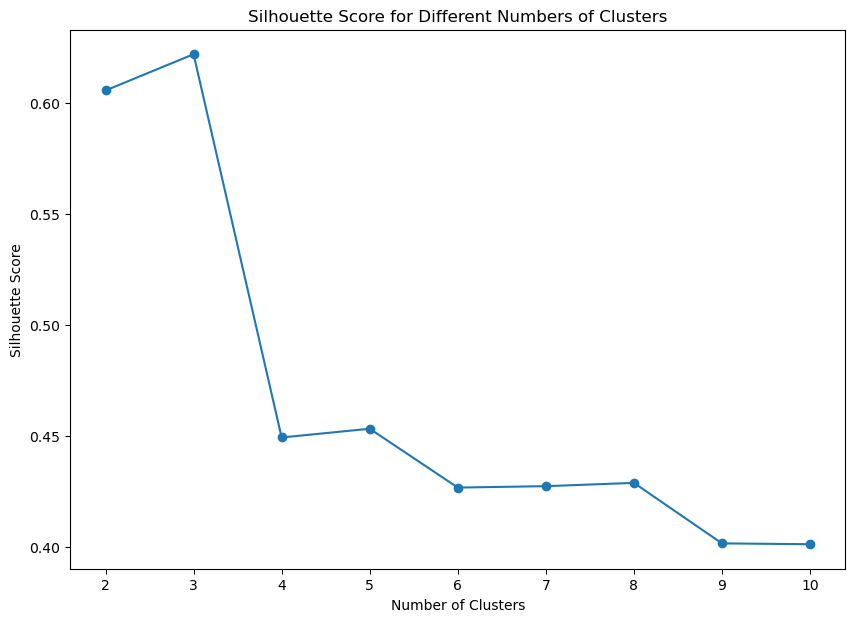

In [49]:
clusters = mmcci.it.lr_clustering(integrated, n_clusters=0)
integrated_clusters = mmcci.it.subset_clusters(integrated, clusters)
overall_clusters = mmcci.it.calculate_cluster_interactions(integrated_clusters)


cluster0: Contains 133 LR pairs


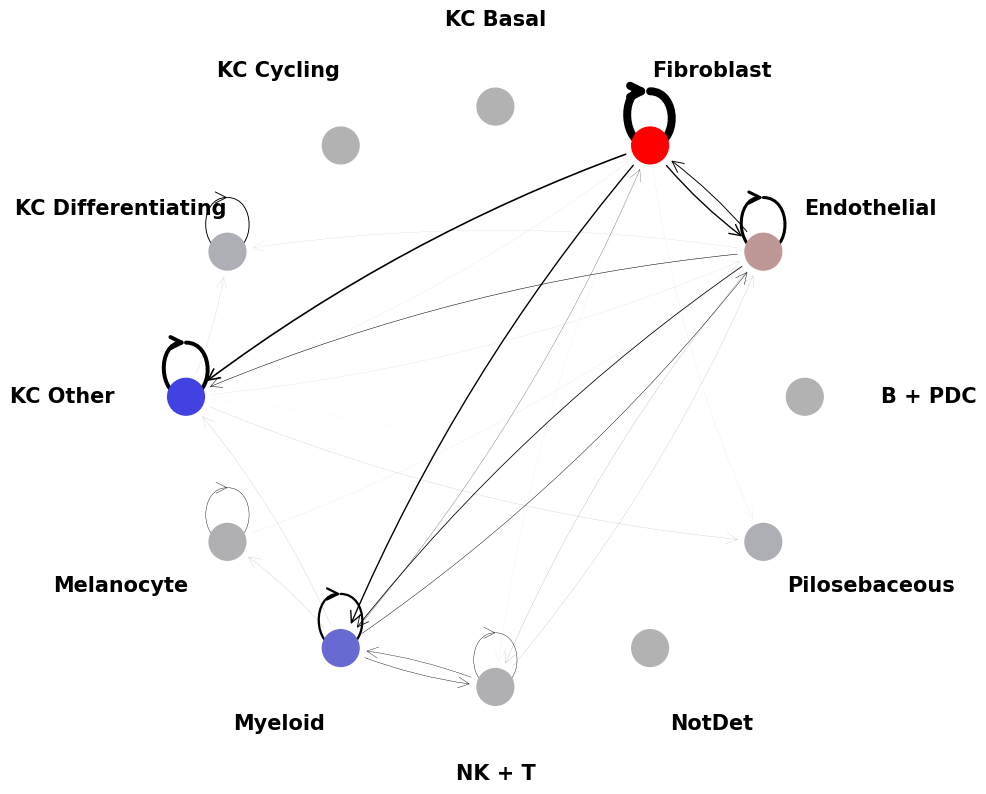


cluster1: Contains 43 LR pairs


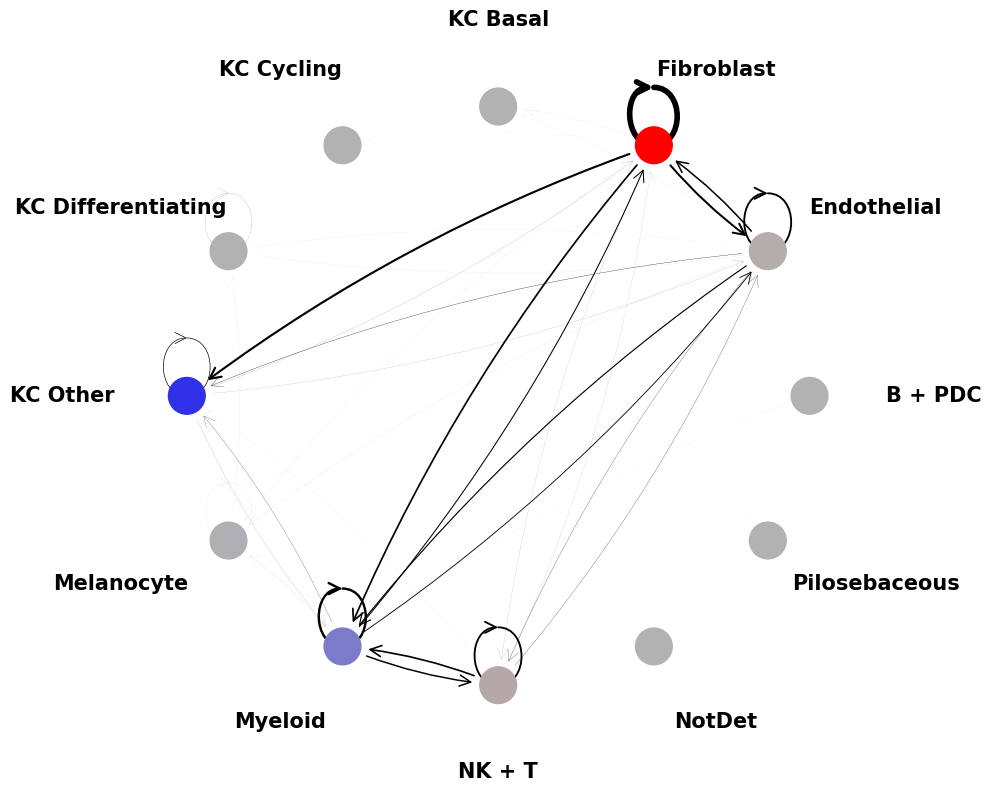


cluster2: Contains 5 LR pairs


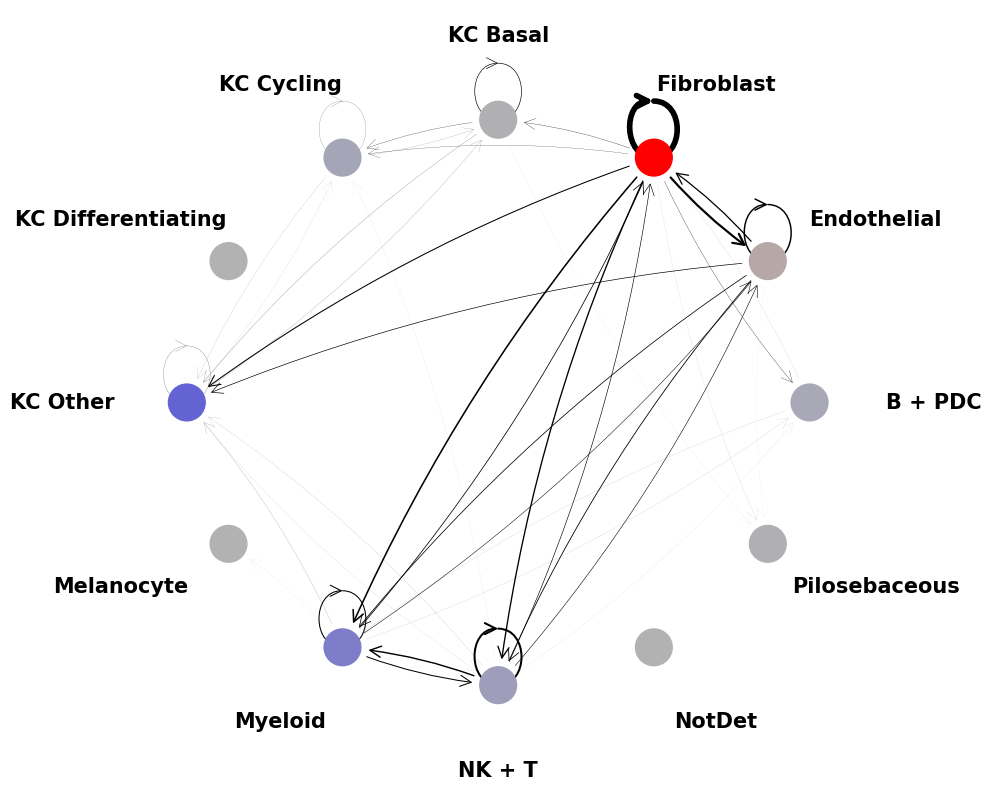

In [50]:
for cluster, matrix in overall_clusters.items():
    print("\ncluster" + str(cluster) + ": Contains " + str(len(integrated_clusters[cluster])) + " LR pairs")
    mmcci.plt.network_plot(matrix)